In [1]:
import argparse
import json
import os
import glob
import re
import numpy as np
import torch
import pandas as pd 
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from fastprogress.fastprogress import master_bar, progress_bar
from attrdict import AttrDict
from transformers import (
    AdamW,
    get_linear_schedule_with_warmup
)

from src import (
    CONFIG_CLASSES,
    TOKENIZER_CLASSES,
    MODEL_FOR_SEQUENCE_CLASSIFICATION,
    set_seed,
    compute_metrics
)

from processor import seq_cls_load_and_cache_examples as load_and_cache_examples
from processor import seq_cls_tasks_num_labels as tasks_num_labels   
from processor import seq_cls_processors as processors
from processor import seq_cls_output_modes as output_modes

2022-09-15 12:05:35.649621: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
task = 'wellness' 
config_dir = '/home/ubuntu/chatbot/code/config/'
config_file = 'koelectra-base.json'

with open(os.path.join(config_dir, task, config_file)) as f:
    args = AttrDict(json.load(f))

args.output_dir = os.path.join(args.ckpt_dir, args.output_dir)
set_seed(args)   # seed 값 설정 

In [3]:
args

AttrDict({'task': 'wellness', 'data_dir': 'data', 'ckpt_dir': 'ckpt', 'train_file': '/home/ubuntu/chatbot/dataset/Wellness_Conversation_intent_train.tsv', 'dev_file': '/home/ubuntu/chatbot/dataset/Wellness_Conversation_intent_val.tsv', 'test_file': '/home/ubuntu/chatbot/dataset/Wellness_Conversation_intent_test.tsv', 'evaluate_test_during_training': True, 'eval_all_checkpoints': True, 'save_optimizer': False, 'do_lower_case': False, 'do_train': True, 'do_eval': True, 'max_seq_len': 128, 'num_train_epochs': 50, 'weight_decay': 0.0, 'gradient_accumulation_steps': 1, 'adam_epsilon': 1e-08, 'warmup_proportion': 0, 'max_steps': -1, 'max_grad_norm': 1.0, 'no_cuda': False, 'model_type': 'koelectra-base', 'model_name_or_path': 'monologg/koelectra-base-discriminator', 'output_dir': 'ckpt/koelectra-base-wellness-ckpt', 'seed': 42, 'train_batch_size': 32, 'eval_batch_size': 128, 'logging_steps': 2000, 'save_steps': 2000, 'learning_rate': 5e-05})

In [4]:
processor = processors[args.task](args) 
labels = processor.get_labels()

# labels
len(labels)

19

In [5]:
config = CONFIG_CLASSES[args.model_type].from_pretrained(   # ElectraConfig.from_pretrained
        args.model_name_or_path,
        num_labels=tasks_num_labels[args.task],   # args.task: wellness, num_labels = 19 
        id2label={str(i): label for i, label in enumerate(labels)},   # labels: ['0', '1', '2', ... ,'18']
        label2id={label: i for i, label in enumerate(labels)},
)

config

ElectraConfig {
  "architectures": [
    "ElectraForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "0",
    "1": "1",
    "10": "10",
    "11": "11",
    "12": "12",
    "13": "13",
    "14": "14",
    "15": "15",
    "16": "16",
    "17": "17",
    "18": "18",
    "2": "2",
    "3": "3",
    "4": "4",
    "5": "5",
    "6": "6",
    "7": "7",
    "8": "8",
    "9": "9"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "0": 0,
    "1": 1,
    "10": 10,
    "11": 11,
    "12": 12,
    "13": 13,
    "14": 14,
    "15": 15,
    "16": 16,
    "17": 17,
    "18": 18,
    "2": 2,
    "3": 3,
    "4": 4,
    "5": 5,
    "6": 6,
    "7": 7,
    "8": 8,
    "9": 9
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_l

In [6]:
tokenizer = TOKENIZER_CLASSES[args.model_type].from_pretrained(   # model_type: koelectra-base, ElectraTokenizer 
    args.model_name_or_path,
    do_lower_case=args.do_lower_case,
    
)

model = MODEL_FOR_SEQUENCE_CLASSIFICATION[args.model_type].from_pretrained(
    args.model_name_or_path,
    config=config
)

Some weights of the model checkpoint at monologg/koelectra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-discriminator and are newly initialized: ['clas

In [7]:
args.device = "cuda" if torch.cuda.is_available() and not args.no_cuda else "cpu"
model.to(args.device)

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(32200, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

In [8]:
model_path = '/home/ubuntu/chatbot/code/model/'
model_name = 'KoELECTRA_intent.pt'

In [9]:
load_model = MODEL_FOR_SEQUENCE_CLASSIFICATION[args.model_type].from_pretrained(
    args.model_name_or_path,
    config=config
)

Some weights of the model checkpoint at monologg/koelectra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-discriminator and are newly initialized: ['clas

In [10]:
args.device = "cuda" if torch.cuda.is_available() and not args.no_cuda else "cpu"

load_model.to(args.device)

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(32200, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

In [11]:
load_model.load_state_dict(torch.load(os.path.join(model_path, model_name)))

<All keys matched successfully>

'''
train_dataset: /home/ubuntu/chatbot/dataset/Wellness_Conversation_intent_train.tsv
test_dataset: /home/ubuntu/chatbot/dataset/Wellness_Conversation_intent_test.tsv
'''

In [12]:
train_dataset = load_and_cache_examples(args, tokenizer, mode="train") if args.train_file else None
dev_dataset = load_and_cache_examples(args, tokenizer, mode="dev") if args.dev_file else None
test_dataset = load_and_cache_examples(args, tokenizer, mode="test") if args.test_file else None

In [13]:
def get_label(args, model, test_dataset):
    results = {}
    test_sampler = SequentialSampler(test_dataset)
    test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=args.eval_batch_size)

    preds = None
    out_label_ids = None

    for batch in progress_bar(test_dataloader):
        model.eval()
        batch = tuple(t.to(args.device) for t in batch)   # args.device: cuda 

        with torch.no_grad():
            inputs = {
                "input_ids": batch[0],
                "attention_mask": batch[1],
                "labels": batch[3]
            }
            if args.model_type not in ["distilkobert", "xlm-roberta"]:
                inputs["token_type_ids"] = batch[2]  # Distilkobert, XLM-Roberta don't use segment_ids
            outputs = model(**inputs)
            tmp_eval_loss, logits = outputs[:2]  
        
        if preds is None:   # 초기 
            preds = logits.detach().cpu().numpy()   # 예측 확률 
            out_label_ids = inputs["labels"].detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)  
            out_label_ids = np.append(out_label_ids, inputs["labels"].detach().cpu().numpy(), axis=0)

    if output_modes[args.task] == "classification":
        preds = np.argmax(preds, axis=1)
        
    return preds, out_label_ids  # label_idx  

In [14]:
y_pred, y_true = get_label(args, load_model, test_dataset)

len(y_pred), len(y_true)

(3936, 3936)

In [15]:
y_true[1], y_pred[1]

(17, 12)

In [16]:
columns = ['우울감', '슬픔', '외로움', '분노', '무기력', '감정조절이상', '상실감', '식욕저하', '식욕증가', \
       '불면', '초조함', '피로', '죄책감', '집중력저하', '자신감저하', '자존감저하', '절망감', '자살충동', '불안']

In [17]:
from sklearn.metrics import precision_score , recall_score , confusion_matrix, f1_score, classification_report

confusion_mt = pd.DataFrame(confusion_matrix(y_true, y_pred))
confusion_mt

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,272,8,5,1,10,1,0,7,0,7,8,2,2,0,0,6,0,2,0
1,4,301,2,14,6,1,0,0,0,1,4,0,16,0,0,3,4,1,1
2,3,6,122,1,7,4,0,1,0,2,3,0,0,0,1,0,2,2,1
3,0,3,0,178,6,2,0,2,0,2,13,0,9,0,0,0,0,2,0
4,8,4,2,5,198,5,1,3,0,4,7,6,3,1,1,1,3,6,0
5,2,3,1,7,3,29,0,0,0,0,3,0,3,0,1,1,1,0,0
6,0,1,0,0,0,0,42,0,0,0,0,0,1,0,0,0,0,0,0
7,1,1,0,0,5,0,0,195,12,1,3,0,0,0,0,0,0,1,0
8,0,0,0,0,0,1,0,4,82,0,0,0,0,0,0,0,0,0,0
9,5,4,1,1,2,0,0,1,0,342,8,6,0,0,0,0,0,1,2


In [18]:
confusion_mt.columns = columns 
confusion_mt.index = columns 

confusion_mt

,우울감,슬픔,외로움,분노,무기력,감정조절이상,상실감,식욕저하,식욕증가,불면,초조함,피로,죄책감,집중력저하,자신감저하,자존감저하,절망감,자살충동,불안
우울감,272,8,5,1,10,1,0,7,0,7,8,2,2,0,0,6,0,2,0
슬픔,4,301,2,14,6,1,0,0,0,1,4,0,16,0,0,3,4,1,1
외로움,3,6,122,1,7,4,0,1,0,2,3,0,0,0,1,0,2,2,1
분노,0,3,0,178,6,2,0,2,0,2,13,0,9,0,0,0,0,2,0
무기력,8,4,2,5,198,5,1,3,0,4,7,6,3,1,1,1,3,6,0
감정조절이상,2,3,1,7,3,29,0,0,0,0,3,0,3,0,1,1,1,0,0
상실감,0,1,0,0,0,0,42,0,0,0,0,0,1,0,0,0,0,0,0
식욕저하,1,1,0,0,5,0,0,195,12,1,3,0,0,0,0,0,0,1,0
식욕증가,0,0,0,0,0,1,0,4,82,0,0,0,0,0,0,0,0,0,0
불면,5,4,1,1,2,0,0,1,0,342,8,6,0,0,0,0,0,1,2


In [19]:
f1 = round(f1_score(y_true, y_pred, average='micro'), 3) 
f1

0.849

In [20]:
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

In [21]:
multiclass_roc_auc_score(y_true, y_pred)

0.9108163798264329

In [22]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.82      0.84       331
           1       0.85      0.84      0.85       358
           2       0.91      0.79      0.84       155
           3       0.76      0.82      0.79       217
           4       0.75      0.77      0.76       258
           5       0.56      0.54      0.55        54
           6       0.95      0.95      0.95        44
           7       0.89      0.89      0.89       219
           8       0.85      0.94      0.90        87
           9       0.89      0.92      0.90       373
          10       0.84      0.91      0.87       540
          11       0.91      0.89      0.90       249
          12       0.81      0.85      0.83       236
          13       0.96      0.90      0.93        49
          14       0.75      0.66      0.70        64
          15       0.87      0.87      0.87       245
          16       0.86      0.75      0.80       144
          17       0.83    

In [23]:
cr = classification_report(y_true, y_pred).split('\n')
cr

['              precision    recall  f1-score   support',
 '',
 '           0       0.86      0.82      0.84       331',
 '           1       0.85      0.84      0.85       358',
 '           2       0.91      0.79      0.84       155',
 '           3       0.76      0.82      0.79       217',
 '           4       0.75      0.77      0.76       258',
 '           5       0.56      0.54      0.55        54',
 '           6       0.95      0.95      0.95        44',
 '           7       0.89      0.89      0.89       219',
 '           8       0.85      0.94      0.90        87',
 '           9       0.89      0.92      0.90       373',
 '          10       0.84      0.91      0.87       540',
 '          11       0.91      0.89      0.90       249',
 '          12       0.81      0.85      0.83       236',
 '          13       0.96      0.90      0.93        49',
 '          14       0.75      0.66      0.70        64',
 '          15       0.87      0.87      0.87       245',
 '       

In [24]:
len(cr)

26

In [25]:
clr_df = []

for idx, line in enumerate(cr):
    clr_df.append([])
    if line == '':
        continue
    
    word_list = line.strip().split(' ')
    
    for word in word_list:
        if word != '':
            clr_df[idx].append(word)

clr_df

[['precision', 'recall', 'f1-score', 'support'],
 [],
 ['0', '0.86', '0.82', '0.84', '331'],
 ['1', '0.85', '0.84', '0.85', '358'],
 ['2', '0.91', '0.79', '0.84', '155'],
 ['3', '0.76', '0.82', '0.79', '217'],
 ['4', '0.75', '0.77', '0.76', '258'],
 ['5', '0.56', '0.54', '0.55', '54'],
 ['6', '0.95', '0.95', '0.95', '44'],
 ['7', '0.89', '0.89', '0.89', '219'],
 ['8', '0.85', '0.94', '0.90', '87'],
 ['9', '0.89', '0.92', '0.90', '373'],
 ['10', '0.84', '0.91', '0.87', '540'],
 ['11', '0.91', '0.89', '0.90', '249'],
 ['12', '0.81', '0.85', '0.83', '236'],
 ['13', '0.96', '0.90', '0.93', '49'],
 ['14', '0.75', '0.66', '0.70', '64'],
 ['15', '0.87', '0.87', '0.87', '245'],
 ['16', '0.86', '0.75', '0.80', '144'],
 ['17', '0.83', '0.88', '0.85', '129'],
 ['18', '0.95', '0.79', '0.86', '184'],
 [],
 ['accuracy', '0.85', '3936'],
 ['macro', 'avg', '0.85', '0.83', '0.84', '3936'],
 ['weighted', 'avg', '0.85', '0.85', '0.85', '3936'],
 []]

In [26]:
clr_df[-2][0] = ' '.join([clr_df[-2][0], clr_df[-2][1]])
clr_df[-3][0] = ' '.join([clr_df[-3][0], clr_df[-3][1]])
clr_df[-4].insert(1, ' ')
clr_df[-4].insert(2, ' ')
clr_df[0].insert(0, 'index')

In [27]:
clr_df[-2].pop(1)
clr_df[-3].pop(1)
clr_df.pop(1)
clr_df.pop(-1)
clr_df.pop(-4)
clr_df

[['index', 'precision', 'recall', 'f1-score', 'support'],
 ['0', '0.86', '0.82', '0.84', '331'],
 ['1', '0.85', '0.84', '0.85', '358'],
 ['2', '0.91', '0.79', '0.84', '155'],
 ['3', '0.76', '0.82', '0.79', '217'],
 ['4', '0.75', '0.77', '0.76', '258'],
 ['5', '0.56', '0.54', '0.55', '54'],
 ['6', '0.95', '0.95', '0.95', '44'],
 ['7', '0.89', '0.89', '0.89', '219'],
 ['8', '0.85', '0.94', '0.90', '87'],
 ['9', '0.89', '0.92', '0.90', '373'],
 ['10', '0.84', '0.91', '0.87', '540'],
 ['11', '0.91', '0.89', '0.90', '249'],
 ['12', '0.81', '0.85', '0.83', '236'],
 ['13', '0.96', '0.90', '0.93', '49'],
 ['14', '0.75', '0.66', '0.70', '64'],
 ['15', '0.87', '0.87', '0.87', '245'],
 ['16', '0.86', '0.75', '0.80', '144'],
 ['17', '0.83', '0.88', '0.85', '129'],
 ['18', '0.95', '0.79', '0.86', '184'],
 ['accuracy', ' ', ' ', '0.85', '3936'],
 ['macro avg', '0.85', '0.83', '0.84', '3936'],
 ['weighted avg', '0.85', '0.85', '0.85', '3936']]

In [28]:
clr_df = pd.DataFrame(clr_df[1:], columns=clr_df[0])
clr_df

,index,precision,recall,f1-score,support
0,0,0.86,0.82,0.84,331
1,1,0.85,0.84,0.85,358
2,2,0.91,0.79,0.84,155
3,3,0.76,0.82,0.79,217
4,4,0.75,0.77,0.76,258
5,5,0.56,0.54,0.55,54
6,6,0.95,0.95,0.95,44
7,7,0.89,0.89,0.89,219
8,8,0.85,0.94,0.90,87
9,9,0.89,0.92,0.90,373


In [29]:
clr_df.index = clr_df['index']

del clr_df['index']
clr_df

,precision,recall,f1-score,support
index,,,,
0,0.86,0.82,0.84,331
1,0.85,0.84,0.85,358
2,0.91,0.79,0.84,155
3,0.76,0.82,0.79,217
4,0.75,0.77,0.76,258
5,0.56,0.54,0.55,54
6,0.95,0.95,0.95,44
7,0.89,0.89,0.89,219
8,0.85,0.94,0.90,87


In [30]:
clr_df.sort_values(by='f1-score', ascending=False)

,precision,recall,f1-score,support
index,,,,
6,0.95,0.95,0.95,44
13,0.96,0.90,0.93,49
11,0.91,0.89,0.90,249
8,0.85,0.94,0.90,87
9,0.89,0.92,0.90,373
7,0.89,0.89,0.89,219
15,0.87,0.87,0.87,245
10,0.84,0.91,0.87,540
18,0.95,0.79,0.86,184


In [31]:
clr_df_1 = clr_df[:11]
clr_df_2 = clr_df[11:]

len(clr_df_1), len(clr_df_2)

(11, 11)

In [32]:
clr_df_1

,precision,recall,f1-score,support
index,,,,
0,0.86,0.82,0.84,331
1,0.85,0.84,0.85,358
2,0.91,0.79,0.84,155
3,0.76,0.82,0.79,217
4,0.75,0.77,0.76,258
5,0.56,0.54,0.55,54
6,0.95,0.95,0.95,44
7,0.89,0.89,0.89,219
8,0.85,0.94,0.90,87


In [33]:
clr_df_2

,precision,recall,f1-score,support
index,,,,
11,0.91,0.89,0.90,249
12,0.81,0.85,0.83,236
13,0.96,0.90,0.93,49
14,0.75,0.66,0.70,64
15,0.87,0.87,0.87,245
16,0.86,0.75,0.80,144
17,0.83,0.88,0.85,129
18,0.95,0.79,0.86,184
accuracy,,,0.85,3936


In [34]:
intent_idx = list(range(len(columns)))
intent_idx

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

In [35]:
from sklearn.preprocessing import label_binarize 

y_true = label_binarize(y_true, classes=intent_idx)
y_pred = label_binarize(y_pred, classes=intent_idx)

In [36]:
from sklearn.metrics import roc_curve, auc

n_classes = 19
fpr = dict()
tpr = dict()
roc_auc = dict() 

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:,i], y_pred[:,i]) 
    roc_auc[i] = auc(fpr[i], tpr[i])

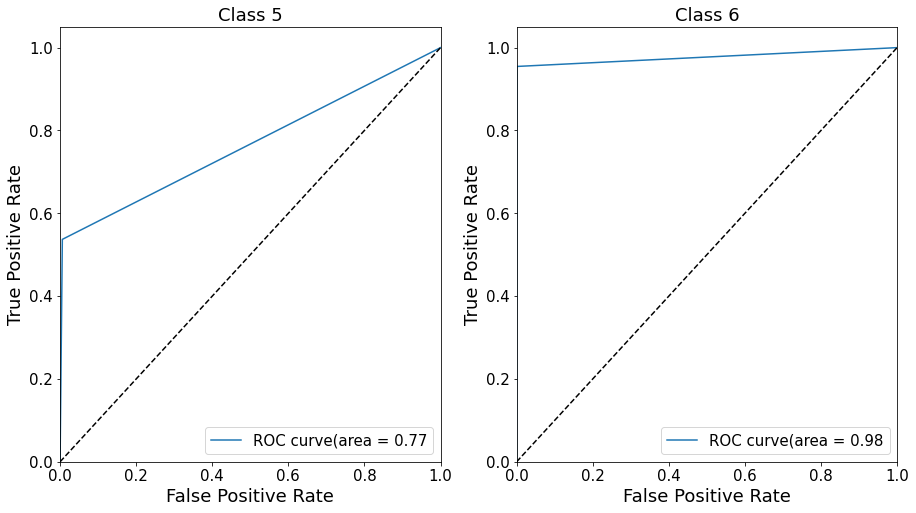

In [37]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(15, 8))
val = 0

# font = {'size': 15}
# plt.rc('font', **font)
plt.rcParams.update({'font.size': 15, 'font.weight': 'normal'})

for idx, i in enumerate(range(n_classes)):
    if idx == 6 or idx == 5: 
        plt.subplot(121+val) 
        plt.plot(fpr[i], tpr[i], label = f'ROC curve(area = {round(roc_auc[i], 2)}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=18) 
        plt.ylabel('True Positive Rate', fontsize=18)
        plt.title(f'Class {idx}', fontsize=18)
        plt.legend(loc='lower right')
        val += 1
plt.show()